# Table of Contents


- **Geting Started**
    - Set Up Environment
    - Import Data
- **ModelTuner**
    - Split Data
    - Find Best Hyper-Params Via Tuner
    - Evaluate
- **Retrain & Evaluate**
    - Set Up `ModelTrainer`
    - Set Up Hyper-Parameters
    - Train & Evaluate

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Getting Started

In this notebook, we'll see how to do find the best potential hyper-parameters for a given model via the **`ModelTuner`** class.

## Set Up Environment

In [3]:
# !pip install oolearning --upgrade

In [4]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreRegressionDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/regression-insurance/1-Exploring.ipynb).

In [5]:
csv_file = '../data/insurance.csv'
target_variable = 'expenses'

explore = ExploreRegressionDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable)

In [6]:
explore.dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# `ModelTuner`

A **`ModelTuner`** is used to search for the best hyper-parameters for a given model. Specifically, a `ModelTuner` uses a `Resampler` object (along with `Scores` objects) in order evaluate the performance of each hyper-paremeter combination. So for example, with the `RepeatedCrossValidationResampler` (with, let's say, 5 folds and 5 repeats), each hyper-parameter combination uses the Resampler object (actually, it is cloned and reused for each combination), and so each hyper-parameter combination is resampled/trained `25` (5x5) times. Each Score's value is recorded for each of the 25 times the model/params are trained/evaluated. So if we want to track 2 scores, perhaps `MAE` and `RMSE`; then each hyper-parameter combination will have 25 `MAE` values and 25 `RMSE` values.

We can then compare the performance between the combinations to choose the best combination, or use the data to inform us about different combinations we might want to try.

## Split Data

First, let's split the data into training/holdout sets, so that we can find the best Hyper-Parameters on the training set and then evaluate on the holdout set.

However, we'll actually ignore the holdout indexes, since we will use a Trainer to do the work for us of refitting the final model on the training data and predicting/evaluating on the holdout data. If we use the same splitter in the Trainer, the split will be the same (i.e. same training data used in the Tuner will be used to refit the final model).

In [8]:
splitter = RegressionStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, _ = splitter.split(target_values=explore.dataset.expenses)  # ignore holdout indexes

In [9]:
training_y = explore.dataset.iloc[training_indexes][target_variable]
training_x = explore.dataset.iloc[training_indexes].drop(columns=target_variable)
training_x.shape

(1070, 6)

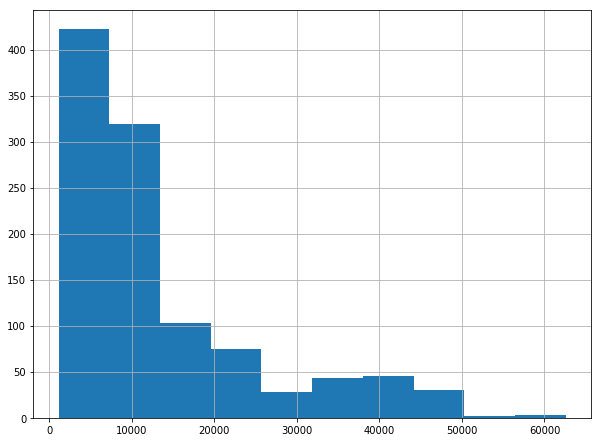

In [11]:
training_y.hist()

## Find Best Hyper-Params via Tuner

Now, let's use a **`ModelTuner`** object to search for the best hyper-parameters for a given model, by evaluating various hyper-parameter combinations. 

In [19]:
# define/configure the resampler
resampler = RepeatedCrossValidationResampler(model=ElasticNetRegressor(),  # using a Random Forest model
                                             transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                                             scores=[MaeScore(), RmseScore()],
                                             folds=5,
                                             repeats=5)
# define/configure the ModelTuner
tuner = ModelTuner(resampler=resampler, hyper_param_object=ElasticNetRegressorHP())

We need to define the combinations of hyper-parameters we want to try out and evalaute.

We'll use a dictionary and a **`HyperParamsGrid`** object to do this.

In [20]:
# define the combinations of hyper-params that we want to evaluate
params_dict = dict(alpha=[0.01, 0.1, 1],
                   l1_ratio=[0, 0.5, 1])
grid = HyperParamsGrid(params_dict=params_dict)

We'll pass the **`HyperParamsGrid`** object to the tuner, which will tell the tuner which combinations of hyper-params to try. We can preview the combinations with **`.params_grid()`**

In [21]:
grid.params_grid

,alpha,l1_ratio
0,0.01,0.0
1,0.01,0.5
2,0.01,1.0
3,0.10,0.0
4,0.10,0.5
5,0.10,1.0
6,1.00,0.0
7,1.00,0.5
8,1.00,1.0


In [22]:
tuner.tune(data_x=training_x, data_y=training_y, params_grid=grid)

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Evaluate

We can see the raw results of the `ModelTuner` via **`tuner.results.resampled_stats`**.

Each hyper-parameter combination that was evaluated is represented by a row, with the columns either representing a particular hyper-parameter, or a Score's statistic (e.g. mean, standard deviation, or coefficient of variation). 

Each Score will be represented with three columns: the **mean** of the resampled Score values (i.e. the mean of the 25 Score values associated with each fold/repeat of the Resampler), the **standard deviation** of the resampled Score values, and the **coefficient of variation** of the values.

In [23]:
tuner.results.resampled_stats

,alpha,l1_ratio,MAE_mean,MAE_st_dev,MAE_cv,RMSE_mean,RMSE_st_dev,RMSE_cv
0,0.01,0.0,4303.041669,317.201669,0.07,6091.993816,521.348578,0.09
1,0.01,0.5,4252.706021,313.538477,0.07,6074.578953,515.636497,0.08
2,0.01,1.0,4205.186642,309.890583,0.07,6069.350303,511.204924,0.08
3,0.10,0.0,5151.726605,368.254152,0.07,7071.113687,624.056686,0.09
4,0.10,0.5,4720.190619,346.276198,0.07,6466.697022,576.433603,0.09
5,0.10,1.0,4205.194882,309.900280,0.07,6069.334383,511.225509,0.08
6,1.00,0.0,8031.799716,428.416471,0.05,10226.590312,711.104451,0.07
7,1.00,0.5,7276.828446,433.456565,0.06,9425.274579,700.540247,0.07
8,1.00,1.0,4205.280779,309.992557,0.07,6069.179916,511.431405,0.08


We can interpret the results easier by visualizing with a heatmap, below.

The hyper-parameter combination that is considered the "best" has a red label on the y-axis. The "best" combination is the one that has the "best" Score (i.e. the Scores that were passed into the Tuner during object creation). If multiple Score objects were passed in, then the first in the list is used (in this case, the first Score we specified above was `AucRocScore`).

Remember, a Score can either be associated with a **utility** function or a **cost** function. A `utility` function (e.g. `AUC`) has score values where higher values represent a better score. A `cost` function (e.g. `error rate`) has score values where lower values represent a better score. This is represented in the heatmap with green (for `utility`) and blue (for `cost`) colors. In both cases, darker colors represent "better" scores. So in the case of `AUC`, higher numbers are better, and associated with darker colors. In the case of `error rate` (or `MAE`/`RMSE`/etc.), lower numbers are better and are also associated with darker numbers. The columns representing `standard deviation` (`SD`) and `coefficient of variation` (`CV`) always have darker colors associated lower numbers, because lower `SD`s and `CV`s represent more consistent results, which is better.

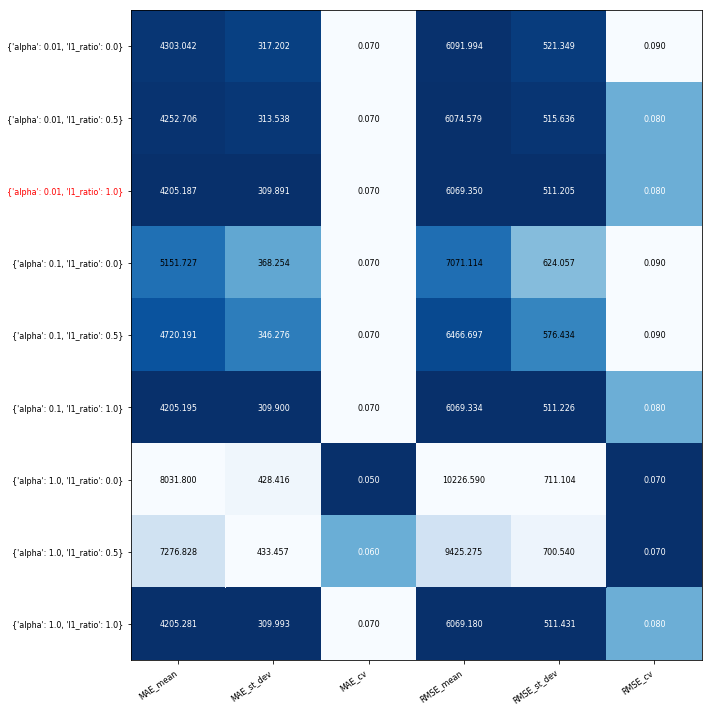

In [24]:
tuner.results.plot_resampled_stats()

In addition to the heatmap, we can also visualize the Resampled score values for a specific metric.

For example, each boxplot below represents the 25 (i.e. 5 fold, 5 repeats) MAE values associated with each of the hyper-parameter combinations that were evaluated.

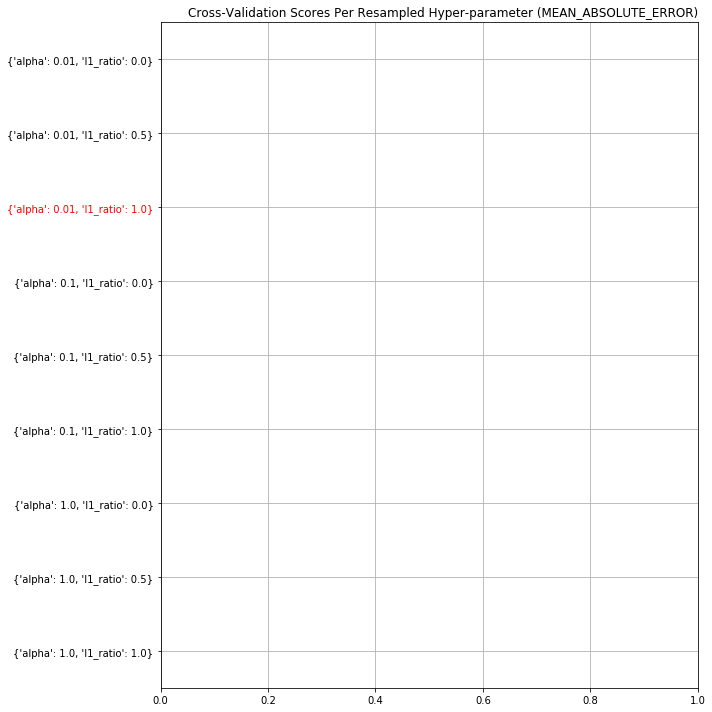

In [26]:
tuner.results.plot_resampled_scores(metric=Metric.MEAN_ABSOLUTE_ERROR)

In addition to the results, we can also access how long it took to resample (5 folds, 5 repeats) each of the combinations.

In [27]:
tuner.results.resampler_times

,alpha,l1_ratio,execution_time
0,0.01,0.0,1 seconds
1,0.01,0.5,1 seconds
2,0.01,1.0,1 seconds
3,0.10,0.0,1 seconds
4,0.10,0.5,1 seconds
5,0.10,1.0,1 seconds
6,1.00,0.0,1 seconds
7,1.00,0.5,1 seconds
8,1.00,1.0,1 seconds


We can also get the metrics associated with the "best" combination. 

As explained above, the hyper-parameter combination that is considered the "best" is the one that has the "best" Score object that was passed into the Tuner. If multiple Score objects were passed in, then the first in the list is used (in this case, the first Score we specified above was `AucRocScore`).

In [28]:
tuner.results.best_model

alpha          0.010000   
l1_ratio       1.000000   
MAE_mean       4205.186642
MAE_st_dev     309.890583 
MAE_cv         0.070000   
RMSE_mean      6069.350303
RMSE_st_dev    511.204924 
RMSE_cv        0.080000   
Name: 2, dtype: float64

And to get the parameter names/values in dictionary format, we can use **`tuner.results.best_hyper_params`**

In [29]:
tuner.results.best_hyper_params

{'alpha': 0.01, 'l1_ratio': 1.0}

Frequently, though, the first time we search across various (sometimes random) hyper-parameters combinations, we will not find the best **possible** combination, since we are evaluating a tiny fraction of all possible combinations. For a given parameter, the ideal value might be above or below the range of values that we tried. Or, our range might have been too wide, and we need to "zoom in" and try more granular values when we have more information about the general vicinity of the ideal value.

**`tuner.results.plot_hyper_params_profile()`** helps us gain a better understanding of the performance of the various parameter values that we tried. We can visualize the performance of a specific hyper-parameter, or a set of hyper-paremeters (and there relationship to eachother).

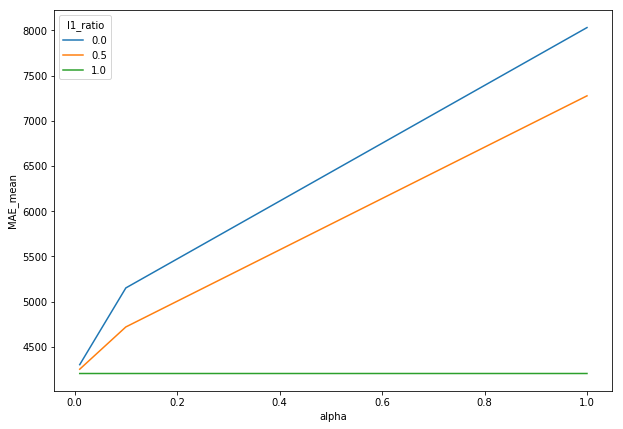

In [33]:
tuner.results.plot_hyper_params_profile(metric=Metric.MEAN_ABSOLUTE_ERROR,
                                        x_axis='alpha',
                                        line='l1_ratio')

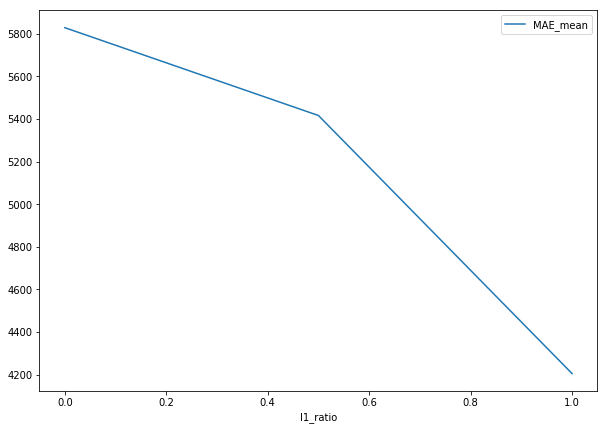

In [34]:
tuner.results.plot_hyper_params_profile(metric=Metric.MEAN_ABSOLUTE_ERROR, x_axis='l1_ratio')

# Retrain & Evaluate

## Set Up `ModelTrainer`

After finding the best hyper-parameters, we want to retrain the model with those parameters on the full training set and predict/evaluate on the holdout set.

As stated previously, since we'll use same type of `Splitter` in the `ModelTrainer`, the training/holdout split will be the same (i.e. same training indexes/data used in the Tuner from the manual split will be used to refit the final model).

Note, instead of using the default threshold of `0.5`, we'll use the threshold calculated by the Decorator via the resampler (associated with the hyper-parameters we are choosing), that makes the best tradeoff between Sensitivity/Specificity, captured via **`calculated_resampled_threshold`**.

In [22]:
# define how we want to split the training/holding datasets
splitter = ClassificationStratifiedDataSplitter(holdout_ratio=0.2)

# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# Define how we want to evaluate (and convert the probabilities DataFrame to predicted classes)
evaluator = TwoClassProbabilityEvaluator(converter=
                                         TwoClassThresholdConverter(threshold=calculated_resampled_threshold,
                                                                    positive_class='lived'))

# give the objects, which encapsulate the behavior of everything involved with training the model, to our ModelTrainer
trainer = ModelTrainer(model=RandomForestClassifier(),
                       model_transformations=transformations,
                       splitter=splitter,
                       evaluator=evaluator)

## Set Up Hyper-Parameters

Let's define the hyper-parameters we want to use.

We know we want to use the **`RandomForestHP`** class, which contains the specific parameters available to train with, but we also know that for some of those, we'll want to update them with the values we found with our `ModelTuner`.

Let's first define our object, and use **`.params_dict`** to see the default hyper-parameters and values.

In [23]:
rf_hyper_params = RandomForestHP()
rf_hyper_params.params_dict

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'oob_score': False}

Now let's update the specific parameters that we found with the `ModelTuner` (which we can access via **`tuner.results.best_hyper_params`**).

We can use **`.update_dict()`**, which conveniently takes a dictionary with the parameter names/values that we want to update (which is what `best_hyper_params` returns) and updates the corresponding values of the hyper-parameters within our object.

In this case, the only parameter that will actually change is `max_features`; the other parameters have values that are the same as the defaults.

In [24]:
rf_hyper_params.update_dict(tuner.results.best_hyper_params)
rf_hyper_params.params_dict

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 24,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'oob_score': False}

## Train & Evaluate

In [25]:
trainer.train(data=explore.dataset, target_variable='Survived', hyper_params=rf_hyper_params)

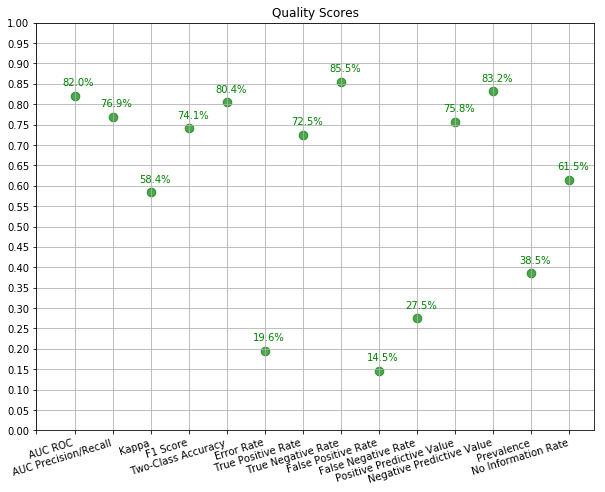

In [26]:
# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.plot_all_quality_metrics()

Again, the `True Positive Rate`, `True Negative Rate`, etc., above is affected by the point on the ROC curve that we used to convert the continuous predictions to `lived` or `died`. We used a threshold of:

In [27]:
calculated_resampled_threshold

0.4599999999999999

rather than `0.5` to convert from the continuous prediction values to predicted classes. Let's see what that looks like on the ROC curve for the holdout set.

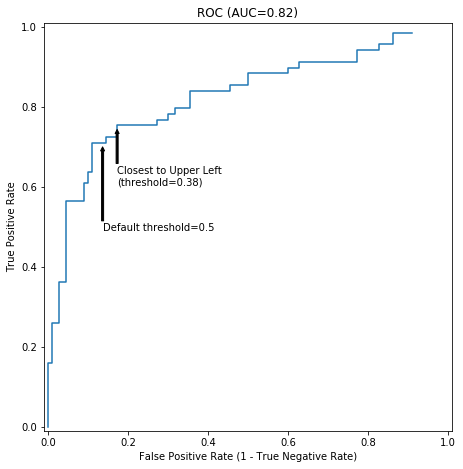

In [29]:
trainer.holdout_evaluator.plot_roc_curve()

The value we used looks to be close to the defualt, but also a little closer to the upper left point on the ROC curve associated with the holdout set.

Now, what about the Precision/Recall curve?

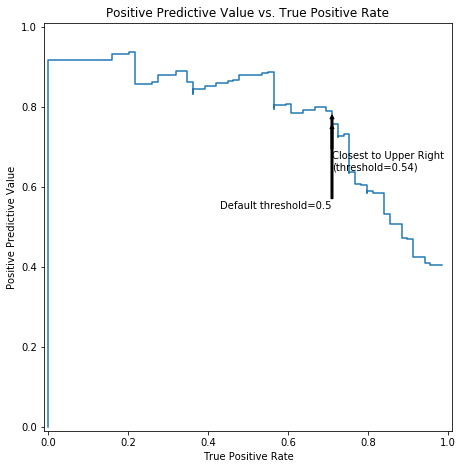

In [30]:
trainer.holdout_evaluator.plot_ppv_tpr_curve()

In the case of the precision recall curve, the value we chose seems to be in the opposite direction of the upper right point of the curve, relative to the default. Perhaps our potential gain in balancing the sensitivity/specificity tradeoff resulted in sacrificing some of the balance of the precision/recall trade-off.

Note: the threshold used in the Score to evaluate the performances was 0.5, rather than using the decorators that find the "ideal" threshold. IMO, in general, it is better to use metrics like AUC that don't depend on the ROC (or Precision-Recall) tradeoffs when searching across models/hyper-parameters, and then once the best model/hyper-parameter is found based on AUC, determine how you want to make tradeoffs based on your particular situation/problem. Of course, if some particular errors are much more important than other errors, this might not be the best approach.